__Nikos Bellos__  
__Member, AUEB Students' Investment and Finance Club__

# Network and Clustering Portfolios on the FTSE 100

This article studies portfolio construction on FTSE 100 equities using methods that make explicit use of the correlation structure between stocks. Using daily data from 2015–2025, we compare classical Markowitz portfolios with network-based and clustering portfolios built from a correlation network. All portfolios are calibrated on the 2015–2017 period and then evaluated over the 2018–2025 period, with the FTSE 100 index as the benchmark.

The idea is to start from a simple reference point (the standard mean–variance optimization) and then ask whether we can obtain better returns by using the empirical correlation network instead of relying only on a flat covariance matrix. To address this question, we:

* Construct Markowitz minimum-variance and maximum-Sharpe portfolios as a baseline.
* Build network portfolios from a thresholded correlation graph and clustering portfolios from a distance-based clustering of stocks.
* Estimate all weights once in the 2015–2017 period and then hold the portfolios long-only from 2018 to 2025.
* Compare realized performance to the FTSE 100 index in terms of annualized returns, volatility, Sharpe ratio, maximum drawdown and tracking error.

In other words, the central question is whether using the empirical FTSE 100 correlation network to guide portfolio construction through both diversified, cluster-based portfolios and more concentrated, "hub based" picks can deliver more robust out-of-sample risk–return profiles than a conventional Markowitz allocation and the FTSE 100 index.

## Setup and Configuration


In [40]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [41]:
IN_SAMPLE_START = '2015'
IN_SAMPLE_END = '2017'
OUT_SAMPLE_START = '2018'
OUT_SAMPLE_END = '2025'
MIN_DATA_AVAILABILITY = 0.90
NETWORK_THRESHOLD_QUANTILE = 0.80
CENTRALITY_THRESHOLD = 20
HIER_MAX_CLUSTERS = 10
HERC_MAX_DEPTH = 10
PERIODS_PER_YEAR = 252

## 1. Data and Preprocessing

- We use daily closing prices for FTSE 100 constituent stocks and the FTSE 100 index from 2015 to 2025. We fix the stock universe to firms that are FTSE 100 members at the end of the sample firms that are delisted or removed from the index before 2025 are excluded, which introduces survivorship bias. The period 2015–2017 is used to estimate the covariance matrix and construct portfolios, while 2018–2025 is reserved exclusively for out-of-sample performance evaluation. We keep only stocks with sufficiently complete price histories, drop trading days where fewer than 90% of our universe have valid prices, and forward-fill short gaps in prices to obtain a balanced panel. From these cleaned prices we compute daily percentage returns and the corresponding return correlation matrix.

In [42]:
def load_ftse100_data(csv_file: str = 'ftse_stock_prices.csv') -> Tuple[pd.DataFrame, List[str]]:
    
    df = pd.read_csv(csv_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    components = [col for col in df.columns if col != 'FTSE100' and col != '.FTSE']
    if '.FTSE' in df.columns:
        df = df.rename(columns={'.FTSE': 'FTSE100'})
    
    metadata = df.copy()
    return metadata, components

metadata, components = load_ftse100_data('ftse_stock_prices.csv')
print(f"Loaded data: {len(components)} stocks, {len(metadata)} trading days")
print(f"Date range: {metadata.index.min().date()} to {metadata.index.max().date()}")
print(f"FTSE100 index included: {'FTSE100' in metadata.columns}")

Loaded data: 100 stocks, 2851 trading days
Date range: 2015-01-02 to 2025-12-05
FTSE100 index included: True


In [43]:
def preprocess_returns(data: pd.DataFrame, components: List[str], min_data_availability: float = 0.9) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    available_components = [c for c in components if c in data.columns]
    if len(available_components) == 0:
        raise ValueError("No components found in data.columns")
    
    data_subset = data[available_components]
    has_data = ~data_subset.isnull().all()
    components_with_data = [c for c in available_components if has_data[c]]
    
    if len(components_with_data) == 0:
        raise ValueError("No stocks have data in the specified period")
    
    non_null_count = data_subset[components_with_data].notna().sum(axis=1)
    total_stocks = len(components_with_data)
    available_pct = non_null_count / total_stocks
    
    valid_dates = available_pct >= min_data_availability
    data_filtered = data_subset[components_with_data].loc[valid_dates].copy()
    
    if len(data_filtered) == 0:
        raise ValueError(f"No dates have at least {min_data_availability*100:.0f}% data availability")
    
    data_filled = data_filtered.ffill()
    
    data_filled = data_filled.dropna()
    
    pctreturn = data_filled.pct_change().dropna()
    
    correlation = pctreturn.corr()
    
    return pctreturn, correlation, data_filled

### Portfolio Utility Functions

Functions to build portfolio value series from prices and weights. Both normalize prices to 1.0 at the start to ensure accurate capital allocation.


In [44]:
def compute_weighted_portfolio(prices: pd.DataFrame, weights: pd.Series, name: str = "portfolio") -> pd.Series:

    common = [c for c in weights.index if c in prices.columns]
    if not common:
        return pd.Series(0.0, index=prices.index, name=name)

    w = weights.loc[common].astype(float).values
    if w.sum() != 0:
        w = w / w.sum()

    normed = prices[common] / prices[common].iloc[0]
    portfolio = (normed * w).sum(axis=1)
    portfolio.name = name
    return portfolio

def compute_equal_weighted_portfolio(prices: pd.DataFrame, selected_stocks: List[str], name: str = "portfolio") -> pd.Series:

    selected = [s for s in selected_stocks if s in prices.columns]
    if not selected:
        return pd.Series(0.0, index=prices.index, name=name)

    normed = prices[selected] / prices[selected].iloc[0]
    portfolio = normed.mean(axis=1)
    portfolio.name = name
    return portfolio

def validate_portfolio_weights(weights: pd.Series, name: str = "portfolio", tolerance: float = 1e-6) -> None:
    assert weights.sum() > 0, f"{name}: weights sum to zero"
    assert abs(weights.sum() - 1.0) < tolerance, f"{name}: weights sum to {weights.sum():.8f}, expected 1.0"
    assert (weights >= 0).all(), f"{name}: contains negative weights"
    assert weights.isna().sum() == 0, f"{name}: contains NaN values"
    assert np.isfinite(weights).all(), f"{name}: contains non-finite values"

def validate_portfolio_value(portfolio_value: pd.Series, name: str = "portfolio", tolerance: float = 0.01) -> None:
    if len(portfolio_value) == 0:
        return
    first_value = portfolio_value.iloc[0]
    assert abs(first_value - 1.0) < tolerance, f"{name}: portfolio starts at {first_value:.6f}, expected ~1.0"
    assert portfolio_value.isna().sum() == 0, f"{name}: contains NaN values"
    assert np.isfinite(portfolio_value).all(), f"{name}: contains non-finite values"
    assert (portfolio_value >= 0).all(), f"{name}: contains negative values"

In [45]:
in_sample_start = IN_SAMPLE_START
in_sample_end = IN_SAMPLE_END
out_sample_start = OUT_SAMPLE_START
out_sample_end = OUT_SAMPLE_END
centrality = CENTRALITY_THRESHOLD

in_sample_data = metadata[in_sample_start:in_sample_end].copy()
in_sample_returns, in_sample_correlation, in_sample_prices = preprocess_returns(
    in_sample_data, components, min_data_availability=MIN_DATA_AVAILABILITY
)

in_sample_data = in_sample_prices.copy()

in_sample_data['FTSE100'] = metadata.loc[in_sample_data.index, 'FTSE100'].ffill()

components = list(in_sample_returns.columns)
print(f"Using {len(components)} stocks with data in the in-sample period")

Using 95 stocks with data in the in-sample period


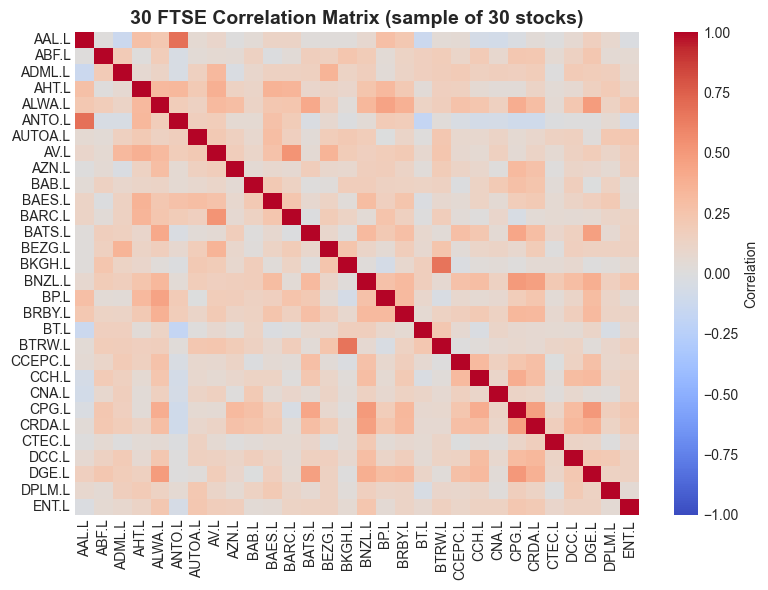

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
sorted_stocks = sorted(in_sample_correlation.index)[:30]
corr_subset = in_sample_correlation.loc[sorted_stocks, sorted_stocks]
sns.heatmap(corr_subset, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            xticklabels=True, yticklabels=True, ax=ax, 
            cbar_kws={'label': 'Correlation'})
ax.set_title('30 FTSE Correlation Matrix (sample of 30 stocks)', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

corr_vals = in_sample_correlation.values
upper = corr_vals[np.triu_indices_from(corr_vals, k=1)]
upper = upper[~np.isnan(upper)]

threshold_quantile = NETWORK_THRESHOLD_QUANTILE
threshold = np.quantile(upper, threshold_quantile)

We use a threshold quantile of $q = 0.80$ for the network portfolios we build later. This keeps only the strongest 20% of correlations as edges in the network.

In [47]:
print(f"\nCorrelation statistics: mean={upper.mean():.3f}, median={np.median(upper):.3f}, std={upper.std():.3f}")
print(f"Network threshold (q={threshold_quantile:.2f}): {threshold:.3f}")


Correlation statistics: mean=0.159, median=0.147, std=0.128
Network threshold (q=0.80): 0.258


## 2. Portfolio Construction
### 2.1 Markowitz Mean-Variance Optimization

The intuition is straightforward: the minimum-variance portfolio tries to make returns as smooth as possible (low risk), while the maximum-Sharpe portfolio tries to achieve the highest average return per unit of risk.

The Markowitz (1952) framework forms the foundation of modern portfolio theory. We implement two variants:

#### 2.1.1 Minimum-Variance Portfolio

The global minimum-variance portfolio minimizes portfolio variance subject to the constraint that weights sum to one:

$$\min_{\mathbf{w}} \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w} \quad \text{subject to} \quad \mathbf{1}^T \mathbf{w} = 1$$

The solution is:

$$\mathbf{w}_{\text{minvar}} = \frac{\boldsymbol{\Sigma}^{-1} \mathbf{1}}{\mathbf{1}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}}$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of returns, and $\mathbf{1}$ is a vector of ones.

#### 2.1.2 Maximum-Sharpe Portfolio

The maximum-Sharpe portfolio maximizes the risk-adjusted return (Sharpe ratio), assuming a risk-free rate of zero:

$$\max_{\mathbf{w}} \frac{\boldsymbol{\mu}^T \mathbf{w}}{\sqrt{\mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}}} \quad \text{subject to} \quad \mathbf{1}^T \mathbf{w} = 1$$

The solution is:

$$\mathbf{w}_{\text{maxsharpe}} = \frac{\boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}}{\mathbf{1}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}}$$

where $\boldsymbol{\mu}$ is the vector of expected returns.

In practice, we impose long-only weights by setting any negative weights to zero and renormalizing the remainder, instead of solving the full constrained Markowitz optimization problem.

In [48]:
def compute_markowitz_weights(returns: pd.DataFrame, allow_short: bool = False) -> Tuple[pd.Series, pd.Series]:
    returns = returns.dropna(axis=1, how='all')
    mu = returns.mean()
    Sigma = returns.cov()
    Sigma_inv = np.linalg.pinv(Sigma.values)
    ones = np.ones(len(mu))
    w_minvar = Sigma_inv @ ones
    denom_minvar = ones @ w_minvar
    if denom_minvar != 0:
        w_minvar = w_minvar / denom_minvar
    w_maxsharpe = Sigma_inv @ mu.values
    denom_maxsharpe = w_maxsharpe.sum()
    if denom_maxsharpe != 0:
        w_maxsharpe = w_maxsharpe / denom_maxsharpe
    if not allow_short:
        w_minvar = np.maximum(w_minvar, 0.0)
        if w_minvar.sum() > 0:
            w_minvar = w_minvar / w_minvar.sum()
        w_maxsharpe = np.maximum(w_maxsharpe, 0.0)
        if w_maxsharpe.sum() > 0:
            w_maxsharpe = w_maxsharpe / w_maxsharpe.sum()
    w_minvar = pd.Series(w_minvar, index=mu.index, name='markowitz_minvar')
    w_maxsharpe = pd.Series(w_maxsharpe, index=mu.index, name='markowitz_maxsharpe')
    return w_minvar, w_maxsharpe

minvar_w, maxsharpe_w = compute_markowitz_weights(in_sample_returns, allow_short=False)
validate_portfolio_weights(minvar_w, 'Markowitz Min-Var')
validate_portfolio_weights(maxsharpe_w, 'Markowitz Max-Sharpe')
in_sample_data['markowitz_minvar'] = compute_weighted_portfolio(in_sample_data, minvar_w, 'markowitz_minvar')
in_sample_data['markowitz_maxsharpe'] = compute_weighted_portfolio(in_sample_data, maxsharpe_w, 'markowitz_maxsharpe')
validate_portfolio_value(in_sample_data['markowitz_minvar'], 'Markowitz Min-Var')
validate_portfolio_value(in_sample_data['markowitz_maxsharpe'], 'Markowitz Max-Sharpe')

print("Minimum-Variance Portfolio:")
print("=" * 70)
print(f"Number of stocks: {(minvar_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_minvar_all = minvar_w[minvar_w > 0.001].sort_values(ascending=False)
top_minvar = top_minvar_all.head(3)
bottom_minvar = top_minvar_all.tail(3)
for stock, weight in top_minvar.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_minvar.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("\n" + "=" * 70)

print("\nMaximum-Sharpe Portfolio:")
print("=" * 70)
print(f"Number of stocks: {(maxsharpe_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_maxsharpe_all = maxsharpe_w[maxsharpe_w > 0.001].sort_values(ascending=False)
top_maxsharpe = top_maxsharpe_all.head(3)
bottom_maxsharpe = top_maxsharpe_all.tail(3)
for stock, weight in top_maxsharpe.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_maxsharpe.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)

Minimum-Variance Portfolio:
Number of stocks: 52

Top 3 and Bottom 3 holdings:
  ALWA.L                 7.20%
  SSE.L                  7.07%
  FCIT.L                 5.17%
  ...
  BTRW.L                 0.29%
  BAB.L                  0.28%
  HLMA.L                 0.19%


Maximum-Sharpe Portfolio:
Number of stocks: 42

Top 3 and Bottom 3 holdings:
  REL.L                  6.98%
  ALWA.L                 6.64%
  SGRO.L                 6.51%
  ...
  RTO.L                  0.28%
  KGF.L                  0.24%
  HSBA.L                 0.20%


### 2.2 Network Portfolios

#### 2.2.1 Degeneracy Ordering Portfolio

This method builds a diversified portfolio by selecting stocks that avoid strong pairwise correlations. An independent set is a group of stocks where no two stocks are directly connected by an edge in the thresholded correlation network.

We proceed as follows:

- Start from the thresholded correlation network, where edges represent only the strongest pairwise correlations.

- Identify isolated nodes (degree 0) and include them directly in the portfolio.

- For the remaining connected nodes, use core numbers as an ordering to greedily construct an independent set: stocks are added only if they are not directly connected to any already selected stock.

By construction, no two selected stocks share a strong correlation link. This results in a portfolio with very low direct correlation between holdings, leading to a strongly diversified allocation that spreads risk across different parts of the market.

In [49]:
def create_graph(components: List[str], correlation: pd.DataFrame, 
                 threshold: float) -> Tuple[nx.Graph, Dict]:
    
    graph = nx.Graph()
    valid_components = [c for c in components if c in correlation.index and c in correlation.columns]
    graph.add_nodes_from(valid_components)
    
    for i in range(len(valid_components)):
        for j in range(i + 1, len(valid_components)):
            stock_i = valid_components[i]
            stock_j = valid_components[j]
            if stock_i in correlation.index and stock_j in correlation.columns:
                corr_val = correlation.loc[stock_i, stock_j]
                if corr_val > threshold:
                    graph.add_edge(stock_i, stock_j, weight=corr_val)
    
    layout = nx.spring_layout(graph, seed=42) if len(graph.nodes) > 0 else {}
    return graph, layout

def create_full_correlation_graph(components: List[str], correlation: pd.DataFrame) -> nx.Graph:
    
    graph = nx.Graph()
    valid_components = [c for c in components if c in correlation.index and c in correlation.columns]
    graph.add_nodes_from(valid_components)
    
    for i in range(len(valid_components)):
        for j in range(i + 1, len(valid_components)):
            stock_i = valid_components[i]
            stock_j = valid_components[j]
            if stock_i in correlation.index and stock_j in correlation.columns:
                corr_val = correlation.loc[stock_i, stock_j]
                weight = max(corr_val, 0.0)
                if weight > 0:
                    graph.add_edge(stock_i, stock_j, weight=weight)
    return graph

In [50]:
def degeneracy_ordering(graph: nx.Graph, components: List[str]) -> Tuple[List[str], List[str]]:
    isolated = [node for node in graph.nodes() if graph.degree(node) == 0]
    
    non_isolated = [node for node in graph.nodes() if graph.degree(node) > 0]
    if non_isolated:
        subgraph = graph.subgraph(non_isolated)
        degeneracy = dict(sorted(nx.core_number(subgraph).items(), key=lambda x: x[1]))
        independence = []
        for i in degeneracy:
            if not set(subgraph.neighbors(i)).intersection(set(independence)):
                independence.append(i)
    else:
        independence = []
    
    return isolated, independence

In [51]:
in_sample_graph, in_sample_layout = create_graph(components, in_sample_correlation, threshold)
in_sample_full_graph = create_full_correlation_graph(components, in_sample_correlation)

In [52]:
isolated, independence = degeneracy_ordering(in_sample_graph, components)
selected_stocks = isolated + independence
assert len(selected_stocks) > 0, "Degeneracy portfolio: no stocks selected"
assert all(s in in_sample_data.columns for s in selected_stocks), "Degeneracy portfolio: some selected stocks not in price data"
in_sample_data['degeneracy'] = compute_equal_weighted_portfolio(in_sample_data, selected_stocks, 'degeneracy')
validate_portfolio_value(in_sample_data['degeneracy'], 'Degeneracy')
print("Degeneracy Portfolio:")
print("=" * 70)
print(f"Total stocks selected: {len(selected_stocks)}")
print(f"  - Isolated nodes (degree 0): {len(isolated)}")
print(f"  - Independent set from network: {len(independence)}")
print("\nTop 3 and Bottom 3 selected stocks:")
if len(selected_stocks) > 6:
    top_three = selected_stocks[:3]
    bottom_three = selected_stocks[-3:]
    for i, stock in enumerate(top_three, 1):
        print(f"  {i:2d}. {stock}")
    print("  ...")
    for idx, stock in enumerate(bottom_three):
        i = len(selected_stocks) - 2 + idx
        print(f"  {i:2d}. {stock}")
else:
    for i, stock in enumerate(selected_stocks, 1):
        print(f"  {i:2d}. {stock}")
print("=" * 70)

Degeneracy Portfolio:
Total stocks selected: 28
  - Isolated nodes (degree 0): 3
  - Independent set from network: 25

Top 3 and Bottom 3 selected stocks:
   1. PSON.L
   2. CTEC.L
   3. GAW.L
  ...
  26. BP.L
  27. HLMA.L
  28. MRON.L


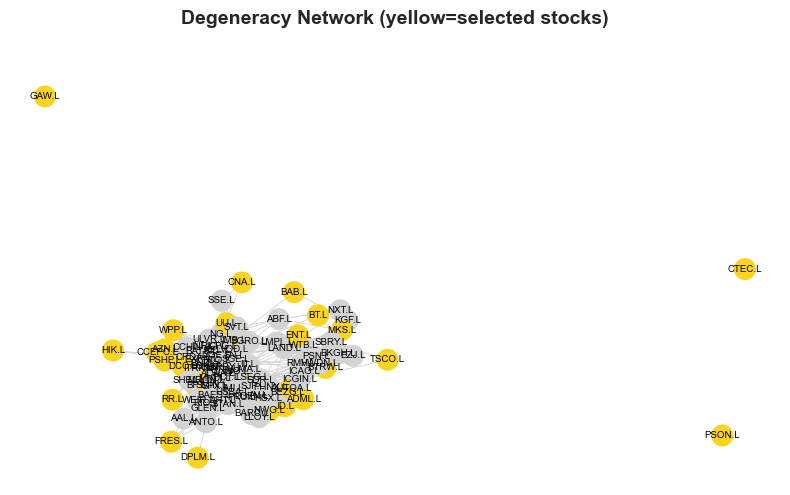

In [53]:
def draw_degeneracy_network(ax, graph, layout, selected, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.axis('off')
        return
    
    node_colors = ['#F9D423' if n in selected else '#D3D3D3' for n in graph.nodes]
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=220,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Degeneracy Network (yellow=selected stocks)',
             fontsize=14, fontweight='bold', y=0.98)

draw_degeneracy_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    selected_stocks,
    'Degeneracy Network (yellow=selected stocks)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

- The thresholded network still contains a meaningful number of nodes and edges, so the 80th-percentile cutoff produces a usable graph rather than an almost empty one. The degeneracy portfolio then selects stocks that are either isolated or not directly linked to each other, which results in a portfolio with very low direct correlation between holdings. In practice, this leads to a strongly diversified allocation that spreads risk across different parts of the market.

#### 2.2.2 Clique Centrality Portfolio

This method identifies hub stocks in the correlation network by counting how often each stock appears in maximal cliques. A maximal clique is a fully connected group of stocks that cannot be expanded by adding another node.

We proceed as follows:

- Find all maximal cliques in the thresholded correlation network.

- Count how many times each stock appears across these cliques (clique membership).

- Select stocks whose clique membership exceeds a chosen threshold.
If no stock meets this threshold, we select the top stocks with the highest clique counts.

The resulting portfolio concentrates on stocks that sit at the centre of many tightly connected groups. These names tend to capture common market or sector movements, leading to a more concentrated and systematic exposure compared to the degeneracy portfolio.

In [54]:
def clique_centrality(graph: nx.Graph, centrality: int = 10, top_k: int = 10) -> List[str]:
    cliques = list(nx.find_cliques(graph))
    if not cliques:
        return []
    
    flat_nodes = [j for i in cliques for j in i]
    counts = {}
    for node in set(flat_nodes):
        counts[node] = flat_nodes.count(node)
    
    selected = [node for node, c in counts.items() if c > centrality]
    
    if not selected:
        selected = [node for node, _ in sorted(counts.items(),
                                               key=lambda x: x[1],
                                               reverse=True)[:top_k]]
    return selected

In [55]:
clique_selected = clique_centrality(in_sample_graph, centrality)
assert len(clique_selected) > 0, "Clique portfolio: no stocks selected"
assert all(s in in_sample_data.columns for s in clique_selected), "Clique portfolio: some selected stocks not in price data"
in_sample_data['clique'] = compute_equal_weighted_portfolio(in_sample_data, clique_selected, 'clique')
validate_portfolio_value(in_sample_data['clique'], 'Clique')

print("Clique Centrality Portfolio:")
print("=" * 70)
print(f"Total stocks selected: {len(clique_selected)}")
print("\nTop 3 and Bottom 3 selected stocks (hub stocks in multiple cliques):")
if len(clique_selected) > 6:
    top_three = clique_selected[:3]
    bottom_three = clique_selected[-3:]
    for i, stock in enumerate(top_three, 1):
        print(f"  {i:2d}. {stock}")
    print("  ...")
    for idx, stock in enumerate(bottom_three):
        i = len(clique_selected) - 2 + idx
        print(f"  {i:2d}. {stock}")
else:
    for i, stock in enumerate(clique_selected, 1):
        print(f"  {i:2d}. {stock}")
print("=" * 70)

Clique Centrality Portfolio:
Total stocks selected: 38

Top 3 and Bottom 3 selected stocks (hub stocks in multiple cliques):
   1. SMT.L
   2. CRDA.L
   3. RIO.L
  ...
  36. PCT.L
  37. RTO.L
  38. SGE.L


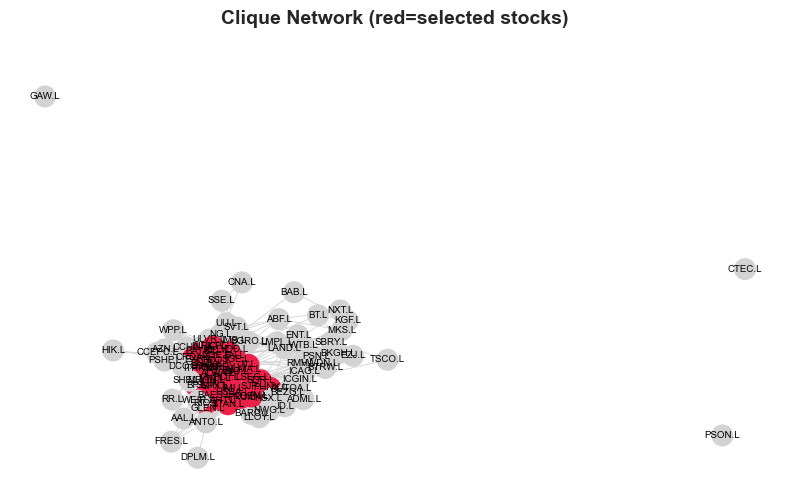

In [56]:

def draw_clique_network(ax, graph, layout, selected, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.axis('off')
        return
    
    node_colors = ['#EC2049' if n in selected else '#D3D3D3' for n in graph.nodes]
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=220,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Clique Network (red=selected stocks)',
             fontsize=14, fontweight='bold', y=0.98)

draw_clique_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    clique_selected,
    'Clique Network (red=selected stocks)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

- Clique centrality selects stocks that lie at the centre of many tightly connected groups in the network. These hub stocks tend to move with large parts of the market, giving the portfolio more systematic exposure. Compared with the degeneracy portfolio, this approach sacrifices some diversification in exchange for a more concentrated, factor-like tilt toward highly correlated names.

#### 2.2.3 Eigenvector Centrality Portfolio

Eigenvector centrality measures a node’s importance recursively: a stock is central if it connects to other central stocks. For the weighted adjacency matrix $\mathbf{W}$, the centrality vector $\mathbf{s}$ satisfies:

$$\lambda \mathbf{s} = \mathbf{W}\mathbf{s}$$

where $\lambda$ is the largest eigenvalue.

We normalize the centrality scores to form a long-only portfolio:
$$\mathbf{w}_{\text{central}} = \frac{\mathbf{s}}{\mathbf{1}^T \mathbf{s}}$$

This portfolio tilts toward the most systemically important stocks in the network.

In [57]:
def eigenvector_centrality_weights(graph: nx.Graph, components: List[str], inverse: bool = False) -> pd.Series:
    if len(graph.nodes) == 0:
        return pd.Series(0.0, index=components, name='eigen_centrality')
    ec_dict = nx.eigenvector_centrality_numpy(graph, weight='weight')
    ec = pd.Series(ec_dict, name='eigen_centrality')
    ec = ec.reindex(components).fillna(0.0)
    if inverse:
        ec = 1.0 / (ec.replace(0, np.nan))
        ec = ec.fillna(0.0)
    if ec.sum() != 0:
        ec = ec / ec.sum()
    return ec

In [58]:
eigen_w_central = eigenvector_centrality_weights(in_sample_full_graph, components, inverse=False)
validate_portfolio_weights(eigen_w_central, 'Eigenvector Centrality')
in_sample_data['eigen_central'] = compute_weighted_portfolio(in_sample_data, eigen_w_central, 'eigen_central')
validate_portfolio_value(in_sample_data['eigen_central'], 'Eigenvector Centrality')

print("Eigenvector Centrality Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(eigen_w_central > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings (by eigenvector centrality):")
top_eigen_all = eigen_w_central[eigen_w_central > 0.001].sort_values(ascending=False)
top_eigen = top_eigen_all.head(3)
bottom_eigen = top_eigen_all.tail(3)
for stock, weight in top_eigen.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_eigen.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)

Eigenvector Centrality Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings (by eigenvector centrality):
  ALWA.L                 1.81%
  FCIT.L                 1.80%
  SMT.L                  1.78%
  ...
  CTEC.L                 0.46%
  PSON.L                 0.34%
  GAW.L                  0.24%


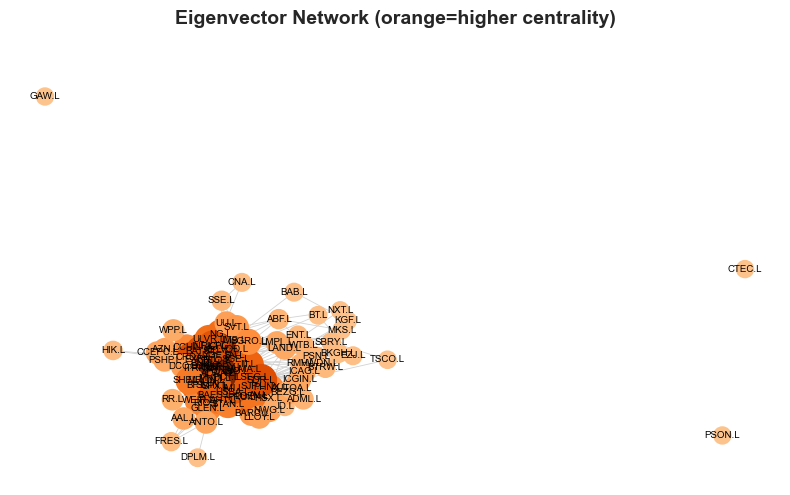

In [59]:
def compute_eigen_centrality_safe(graph):
    
    if len(graph.nodes) == 0:
        return {}
    return nx.eigenvector_centrality(graph, weight='weight', max_iter=1000)

in_ec = compute_eigen_centrality_safe(in_sample_graph)

def draw_eigen_network(ax, graph, layout, ec_dict, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.axis('off')
        return
    
    vals = np.array([ec_dict.get(n, 0.0) for n in graph.nodes])
    if vals.max() > 0:
        norm = vals / vals.max()
    else:
        norm = vals
    
    cmap = plt.cm.Oranges
    node_colors = [cmap(0.3 + 0.7 * v) for v in norm]  
    node_sizes = 150 + 600 * norm                      
    
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=node_sizes,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Eigenvector Network (orange=higher centrality)',
             fontsize=14, fontweight='bold', y=0.98)

draw_eigen_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    in_ec,
    'Eigenvector Network (orange=higher centrality)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

- Node size and colour intensity reflect eigenvector centrality: a stock becomes important if it is connected to other important stocks.
- The eigenvector centrality portfolio overweights these nodes in the positive correlation graph, not only in the thresholded graph we draw.
- As a result, this portfolio behaves a bit like a "network beta" trade: it has high exposure to the main market mode and less idiosyncratic diversification.

### 2.3 Clustering Portfolios

- We cluster stocks using correlation-derived distances, then allocate weights recursively down the resulting dendrogram. This approach organizes stocks into a hierarchy based on their correlation structure before assigning weights, which can produce more robust portfolios than working directly with the full covariance matrix.

Before constructing clustering portfolios, we need to convert correlation matrices into distance matrices that can be used for clustering. The functions below implement two distance metrics:

- Correlation Distance Matrix converts pairwise correlations $\rho_{ij}$ into distances using the standard transformation $d_{ij} = \sqrt{\tfrac{1}{2}(1 - \rho_{ij})}$. This maps high correlations (close to 1) to small distances and low correlations to large distances.

- and Correlation Profile Distance measures how similar two assets are in terms of their correlation profiles with all other assets, not just their pairwise correlation. For each pair of assets $i$ and $j$, we compute the Euclidean distance between their correlation vectors (how they correlate with all other assets). This captures second-order relationships and tends to produce cleaner hierarchical clusters that align better with sectors or shared risk factors.

This approach is particularly useful for clustering portfolio construction methods (HRP, HERC, hierarchical 1/N) as it captures more nuanced similarity structures than simple pairwise correlations.


In [60]:
def corr_distance_matrix(correlation: pd.DataFrame) -> np.ndarray:
    
    corr_values = correlation.values.copy()
    np.fill_diagonal(corr_values, 1.0)
    distance = np.sqrt(0.5 * (1 - corr_values))
    np.fill_diagonal(distance, 0.0)
    return distance

def corr_distance_of_distance_matrix(correlation: pd.DataFrame) -> np.ndarray:
    
    D = corr_distance_matrix(correlation)
    
    n = D.shape[0]
    Dtilde = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(D[:, i] - D[:, j])
            Dtilde[i, j] = dist
            Dtilde[j, i] = dist
    
    np.fill_diagonal(Dtilde, 0.0)
    return Dtilde

#### 2.3.1 Cluster Equal-Weight Portfolio

We cluster on correlation distance and cut the dendrogram into 10 clusters. Each cluster gets equal weight: $$(1/K)$$ and within a cluster weights are equal across its members:

$$ \quad w_i = \frac{1}{K \cdot n_c}$$

This yields broad diversification across the discovered correlation clusters.

In [61]:
def hierarchical_clusters_from_corr(correlation: pd.DataFrame, method: str = 'average', max_clusters: int = 10) -> Tuple[pd.Series, np.ndarray]:
    
    corr = correlation.copy()
    corr = corr.fillna(0.0)
    np.fill_diagonal(corr.values, 1.0)
    corr = corr.clip(-1.0, 1.0)
    dist = np.sqrt(0.5 * (1 - corr.values))
    dist = np.nan_to_num(dist, nan=1.0, posinf=1.0, neginf=1.0)
    condensed = squareform(dist, checks=False)
    condensed = np.nan_to_num(condensed, nan=1.0, posinf=1.0, neginf=1.0)
    Z = linkage(condensed, method=method)
    labels = fcluster(Z, max_clusters, criterion='maxclust')
    labels = pd.Series(labels, index=correlation.index, name='cluster')
    return labels, Z

def cluster_equal_weights(labels: pd.Series) -> pd.Series:
    weights = pd.Series(0.0, index=labels.index)
    clusters = labels.unique()
    n_clusters = len(clusters)
    for c in clusters:
        members = labels.index[labels == c]
        if len(members) == 0:
            continue
        weights.loc[members] = 1.0 / (n_clusters * len(members))
    weights.name = 'cluster_equal'
    return weights

In [62]:
cluster_labels, Z = hierarchical_clusters_from_corr(
    in_sample_correlation, method='average', max_clusters=HIER_MAX_CLUSTERS
)
cluster_w = cluster_equal_weights(cluster_labels)
validate_portfolio_weights(cluster_w, 'Cluster Equal')
in_sample_data['cluster_equal'] = compute_weighted_portfolio(in_sample_data, cluster_w, 'cluster_equal')
validate_portfolio_value(in_sample_data['cluster_equal'], 'Cluster Equal')

print("Hierarchical Clustering Portfolio:")
print("=" * 70)
print(f"Number of clusters: {cluster_labels.nunique()}")
print("\nCluster composition (all clusters):")
sorted_clusters = sorted(cluster_labels.unique())
for cluster_id in sorted_clusters:
    members = cluster_labels[cluster_labels == cluster_id].index.tolist()
    members_str = ", ".join(members)
    print(f"\nCluster {cluster_id} ({len(members)} stocks):")
    print(members_str)
print("=" * 70)

Hierarchical Clustering Portfolio:
Number of clusters: 10

Cluster composition (all clusters):

Cluster 1 (1 stocks):
PSHP.L

Cluster 2 (1 stocks):
GAW.L

Cluster 3 (2 stocks):
KGF.L, BAB.L

Cluster 4 (16 stocks):
BTRW.L, WTB.L, PSN.L, JD.L, MKS.L, RMV.L, HWDN.L, EZJ.L, ABF.L, ENT.L, ICAG.L, AUTOA.L, NXT.L, TSCO.L, BKGH.L, SBRY.L

Cluster 5 (1 stocks):
BT.L

Cluster 6 (2 stocks):
DPLM.L, HIK.L

Cluster 7 (40 stocks):
BP.L, SMT.L, SGE.L, GSK.L, INF.L, MNDI.L, BNZL.L, ITRK.L, VOD.L, LAND.L, CCH.L, IMB.L, SN.L, BATS.L, RTO.L, AZN.L, SSE.L, LMPL.L, CPG.L, CNA.L, IHG.L, DGE.L, ULVR.L, WPP.L, CCEPC.L, FCIT.L, EXPN.L, CRDA.L, NG.L, UU.L, PCT.L, III.L, DCC.L, BRBY.L, REL.L, ALWA.L, SVT.L, SGRO.L, RKT.L, SHEL.L

Cluster 8 (30 stocks):
RR.L, GLEN.L, AV.L, FRES.L, RIO.L, BAES.L, NWG.L, LSEG.L, AHT.L, HLMA.L, BARC.L, HSBA.L, PRU.L, PHNX.L, WEIR.L, MRON.L, ADML.L, HSX.L, BEZG.L, SMIN.L, SJP.L, STAN.L, AAL.L, LGEN.L, ANTO.L, IMI.L, SPX.L, LLOY.L, ICGIN.L, SDR.L

Cluster 9 (1 stocks):
PSON.L

Cluster

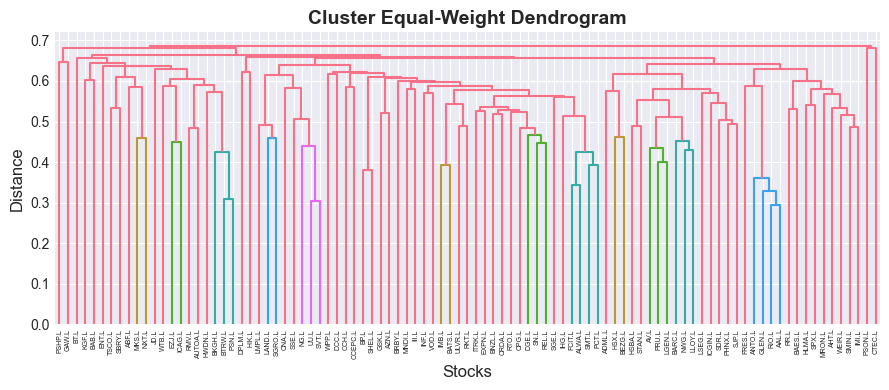

In [63]:
fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('Cluster Equal-Weight Dendrogram', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

#### 2.3.2 Hierarchical 1/N (Waterfall)

This method uses the hierarchical structure from clustering without any risk estimates. It provides a simple baseline that shows how the hierarchy alone affects portfolio allocation.

We proceed as follows:

- Measure how similar stocks are in terms of their correlation profiles with all other stocks (not just pairwise correlations), then perform Ward-linkage hierarchical clustering to obtain a dendrogram (same dendrogram shown below in the HERC section).

- Start with all capital at the root of the tree and recursively split weights 50/50 at each branch down the dendrogram.

- Within each terminal group, allocate weights equally across stocks.

This approach allocates more weight to stocks that appear earlier in the dendrogram, reflecting their position in the correlation hierarchy.

In [64]:
def hierarchical_one_over_n_weights(
    correlation: pd.DataFrame,
    linkage_method: str = "ward",
    use_distance_of_distance: bool = False,
) -> pd.Series:
    
    if use_distance_of_distance:
        distance_matrix = corr_distance_of_distance_matrix(correlation)
    else:
        distance_matrix = corr_distance_matrix(correlation)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    n_items = len(correlation.index)
    root_cluster_id = 2 * n_items - 2
    weights_dict = {i: 0.0 for i in range(n_items)}
    
    def assign_weight_recursive(cluster_id: int, weight: float):
        
        if cluster_id < n_items:
            weights_dict[cluster_id] = weight
        else:
            cluster_idx = cluster_id - n_items
            left_child = int(linkage_matrix[cluster_idx, 0])
            right_child = int(linkage_matrix[cluster_idx, 1])
            assign_weight_recursive(left_child, weight / 2.0)
            assign_weight_recursive(right_child, weight / 2.0)
    
    assign_weight_recursive(root_cluster_id, 1.0)
    weights = pd.Series([weights_dict[i] for i in range(n_items)], index=correlation.index)
    weights = weights / weights.sum()
    weights.name = 'hier_1N'
    return weights

In [65]:
distance_h1n = corr_distance_of_distance_matrix(in_sample_correlation)
condensed_dist_h1n = squareform(distance_h1n, checks=False)
Z_h1n = linkage(condensed_dist_h1n, method='ward')

In [66]:
h1n_weights = hierarchical_one_over_n_weights(
    in_sample_correlation,
    linkage_method="ward",
    use_distance_of_distance=True
)
validate_portfolio_weights(h1n_weights, 'Hierarchical 1/N')
in_sample_data["hier_1N"] = compute_weighted_portfolio(in_sample_data, h1n_weights, "hier_1N")
validate_portfolio_value(in_sample_data["hier_1N"], 'Hierarchical 1/N')

print("Hierarchical 1/N Portfolio (Waterfall):")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(h1n_weights > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_h1n_all = h1n_weights[h1n_weights > 0.001].sort_values(ascending=False)
top_h1n = top_h1n_all.head(3)
bottom_h1n = top_h1n_all.tail(3)
for stock, weight in top_h1n.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_h1n.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)

Hierarchical 1/N Portfolio (Waterfall):
Number of stocks with non-zero weight: 87

Top 3 and Bottom 3 holdings:
  ANTO.L                 6.25%
  AAL.L                  3.12%
  FRES.L                 3.12%
  ...
  CPG.L                  0.20%
  SPX.L                  0.20%
  SBRY.L                 0.20%


#### 2.3.3 Hierarchical Risk Parity (HRP) Portfolio

This method allocates weights inversely to cluster variances while respecting the hierarchical structure. Lower-variance clusters receive more capital, similar to an inverse-variance portfolio, but applied recursively down the dendrogram.

We proceed as follows:

- Measure how similar stocks are in terms of their correlation profiles with all other stocks, then perform single-linkage hierarchical clustering to obtain a dendrogram.

- Quasi-diagonalize the covariance matrix according to the dendrogram ordering, so that similar assets sit next to each other.

- Apply recursive bisection: at each split, divide the current cluster into two subclusters, compute their variances using an inverse-variance portfolio within each subcluster, and allocate cluster weight inversely to these variances:
  $$\alpha = \frac{\sigma_2^2}{\sigma_1^2 + \sigma_2^2}, \quad
  1 - \alpha = \frac{\sigma_1^2}{\sigma_1^2 + \sigma_2^2}$$
  where $\sigma_1^2$ and $\sigma_2^2$ are the variances of the two subclusters.

By tilting weight toward lower-variance clusters while respecting the hierarchical structure, HRP produces a diversified portfolio that accounts for both correlation patterns and individual asset risk, typically more robust than a flat mean–variance optimization.


In [67]:
def compute_inverse_variance_portfolio(cov_matrix: np.ndarray) -> np.ndarray:
    
    variances = np.diag(cov_matrix)
    inv_variances = 1.0 / np.maximum(variances, 1e-10)
    weights = inv_variances / inv_variances.sum()
    return weights

def compute_cluster_variance(cov_matrix: np.ndarray) -> float:
    
    if cov_matrix.shape[0] == 1:
        return cov_matrix[0, 0]
    
    w = compute_inverse_variance_portfolio(cov_matrix)
    variance = w.T @ cov_matrix @ w
    return variance

def quasi_diagonalize(linkage_matrix: np.ndarray, n_items: int) -> List[int]:
    
    sorted_index = [int(linkage_matrix[-1, 0]), int(linkage_matrix[-1, 1])]
    
    while True:
        to_expand = []
        for i, idx in enumerate(sorted_index):
            if idx >= n_items:
                to_expand.append((i, idx - n_items))
        
        if not to_expand:
            break
        
        for pos, cluster_idx in reversed(to_expand):
            merged_1 = int(linkage_matrix[cluster_idx, 0])
            merged_2 = int(linkage_matrix[cluster_idx, 1])
            
            sorted_index[pos] = merged_1
            sorted_index.insert(pos + 1, merged_2)
    
    return sorted_index

def hrp_weights(covariance: pd.DataFrame, linkage_method: str = 'single') -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    correlation_df = pd.DataFrame(correlation, index=covariance.index, columns=covariance.index)
    
    distance_matrix = corr_distance_of_distance_matrix(correlation_df)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)
    
    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]
    
    weights = pd.Series(1.0, index=sorted_items)
    
    groups = [list(range(n_items))]
    
    while any(len(g) > 1 for g in groups):
        new_groups = []
        
        for group in groups:
            if len(group) <= 1:
                new_groups.append(group)
                continue
            
            mid = len(group) // 2
            group_1 = group[:mid]
            group_2 = group[mid:]
            
            items_1 = [sorted_items[i] for i in group_1]
            items_2 = [sorted_items[i] for i in group_2]
            
            cov_1 = cov_sorted.loc[items_1, items_1].values
            cov_2 = cov_sorted.loc[items_2, items_2].values
            
            var_1 = compute_cluster_variance(cov_1)
            var_2 = compute_cluster_variance(cov_2)
            
            alpha = var_2 / (var_1 + var_2) if (var_1 + var_2) > 0 else 0.5
            
            for i in group_1:
                weights.iloc[i] *= alpha
            for i in group_2:
                weights.iloc[i] *= (1 - alpha)
            
            new_groups.append(group_1)
            new_groups.append(group_2)
        
        groups = new_groups
    
    weights = weights / weights.sum()
    weights.name = 'hrp'
    
    weights = weights.reindex(covariance.index).fillna(0.0)
    
    return weights

Hierarchical Risk Parity (HRP) Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings:
  PSHP.L                 3.43%
  LMPL.L                 2.58%
  REL.L                  2.55%
  ...
  RIO.L                  0.31%
  EZJ.L                  0.30%
  GLEN.L                 0.27%


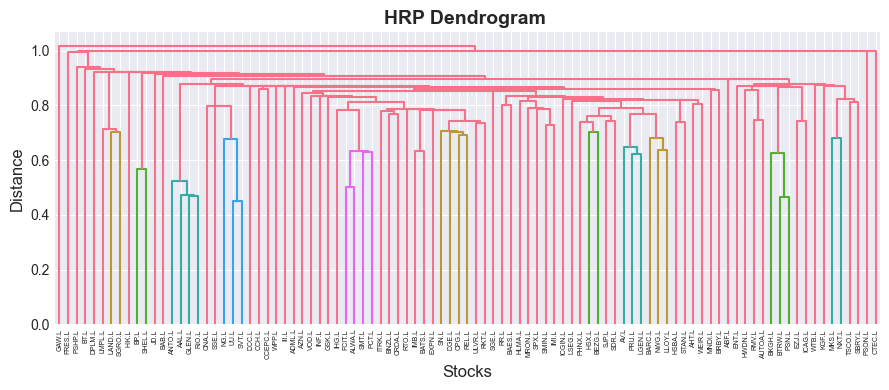

In [68]:
in_sample_cov = in_sample_returns.cov()

hrp_weights_series = hrp_weights(in_sample_cov, linkage_method='single')
validate_portfolio_weights(hrp_weights_series, 'HRP')
in_sample_data['hrp'] = compute_weighted_portfolio(in_sample_data, hrp_weights_series, 'hrp')
validate_portfolio_value(in_sample_data['hrp'], 'HRP')

print("Hierarchical Risk Parity (HRP) Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(hrp_weights_series > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_hrp_all = hrp_weights_series[hrp_weights_series > 0.001].sort_values(ascending=False)
top_hrp = top_hrp_all.head(3)
bottom_hrp = top_hrp_all.tail(3)
for stock, weight in top_hrp.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_hrp.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)

# Plot dendrogram for HRP portfolio
distance_hrp = corr_distance_of_distance_matrix(in_sample_correlation)
condensed_dist_hrp = squareform(distance_hrp, checks=False)
Z_hrp = linkage(condensed_dist_hrp, method='single')

fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z_hrp, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('HRP Dendrogram ', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

#### 2.3.4 Hierarchical Equal Risk Contribution Portfolio (HERC)

This method combines the Ward-linkage dendrogram from hierarchical 1/N with risk-aware allocation similar to HRP. It allocates weights inversely to cluster variances but stops recursion at a maximum depth, then allocates equally within terminal groups.

We proceed as follows:

- Measure how similar stocks are in terms of their correlation profiles with all other stocks, then perform Ward-linkage hierarchical clustering to obtain a dendrogram (same tree as hierarchical 1/N).

- At each split, allocate between the two subclusters inversely to their estimated variances, using equal-weighted portfolios within each subcluster to estimate variance.

- Stop recursion at a maximum depth; within terminal groups, allocate weights equally across stocks.

This approach blends the hierarchical structure with risk-aware allocation, using Ward linkage for more balanced clusters and depth-limited recursion to control complexity.


In [69]:
def herc_weights(
    covariance: pd.DataFrame,
    max_depth: int | None = None,
    linkage_method: str = "ward",
    use_distance_of_distance: bool = True,
) -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    correlation_df = pd.DataFrame(correlation, index=covariance.index, columns=covariance.index)

    if use_distance_of_distance:
        distance_matrix = corr_distance_of_distance_matrix(correlation_df)
    else:
        distance_matrix = corr_distance_matrix(correlation_df)

    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)

    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)

    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]

    weights = pd.Series(0.0, index=sorted_items)

    def split_group_recursive(group: List[int], cluster_weight: float, depth: int = 0):
        
        if len(group) == 1 or (max_depth is not None and depth >= max_depth):
            equal_w = cluster_weight / len(group)
            for i in group:
                weights.iloc[i] += equal_w
            return

        mid = len(group) // 2
        group_1 = group[:mid]
        group_2 = group[mid:]

        items_1 = [sorted_items[i] for i in group_1]
        items_2 = [sorted_items[i] for i in group_2]

        cov_1 = cov_sorted.loc[items_1, items_1].values
        cov_2 = cov_sorted.loc[items_2, items_2].values

        n1, n2 = len(group_1), len(group_2)
        w1_equal = np.ones(n1) / n1
        w2_equal = np.ones(n2) / n2

        var_1 = w1_equal.T @ cov_1 @ w1_equal
        var_2 = w2_equal.T @ cov_2 @ w2_equal

        total_var = var_1 + var_2
        if total_var > 0:
            w1 = var_2 / total_var
            w2 = var_1 / total_var
        else:
            w1 = w2 = 0.5

        split_group_recursive(group_1, cluster_weight * w1, depth + 1)
        split_group_recursive(group_2, cluster_weight * w2, depth + 1)

    split_group_recursive(list(range(n_items)), cluster_weight=1.0, depth=0)

    weights = weights / weights.sum()
    weights.name = 'herc'

    weights = weights.reindex(covariance.index).fillna(0.0)

    return weights

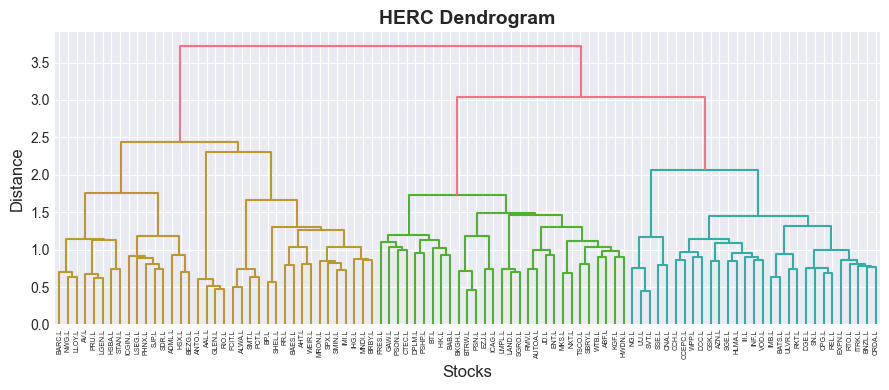

In [70]:
# Note -> HERC uses the same Ward linkage dendrogram as the hierarchical 1/N
fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z_h1n, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('HERC Dendrogram', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

In [71]:
herc_w = herc_weights(
    in_sample_cov,
    max_depth=HERC_MAX_DEPTH,
    linkage_method="ward",
    use_distance_of_distance=True
)
validate_portfolio_weights(herc_w, 'HERC')
in_sample_data["herc"] = compute_weighted_portfolio(in_sample_data, herc_w, "herc")
validate_portfolio_value(in_sample_data["herc"], 'HERC')

print("Depth-Limited Hierarchical Risk Allocation (HERC-style) Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(herc_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_herc_all = herc_w[herc_w > 0.001].sort_values(ascending=False)
top_herc = top_herc_all.head(3)
bottom_herc = top_herc_all.tail(3)
for stock, weight in top_herc.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_herc.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)

Depth-Limited Hierarchical Risk Allocation (HERC-style) Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings:
  PSHP.L                 2.71%
  SGRO.L                 2.38%
  DPLM.L                 2.29%
  ...
  AAL.L                  0.16%
  RIO.L                  0.13%
  GLEN.L                 0.11%


- The clustering portfolios use correlation profiles to group stocks with similar patterns, then allocate weights down the resulting tree. Hierarchical 1/N splits weights 50/50 at each branch (structure-driven). HRP uses single-linkage clustering and allocates inversely to cluster variances. HERC uses the same Ward-linkage tree as hierarchical 1/N but allocates inversely to variances with depth-limited recursion. This "cluster first, allocate second" approach contrasts with flat Markowitz optimization that works directly on the full covariance matrix.

### Performance Metrics

To evaluate portfolio performance, we compute several standard metrics from daily returns. The definitions below explain how each metric is calculated and interpreted. We report all performance numbers at the daily frequency and then annualize them using 252 trading days per year.

- Annualized Mean Return:
$$\mu_{\text{annual}} = 252 \times \bar{r}$$

where $\bar{r} = \frac{1}{T} \sum_{t=1}^T r_t$ is the sample mean of daily returns.

- Annualized Volatility:
$$\sigma_{\text{annual}} = \sqrt{252} \times \hat{\sigma}$$

where $\hat{\sigma} = \sqrt{\frac{1}{T-1} \sum_{t=1}^T (r_t - \bar{r})^2}$ is the sample standard deviation of daily returns.

- Sharpe Ratio (assuming risk-free rate = 0):
$$\text{Sharpe} = \frac{\mu_{\text{annual}}}{\sigma_{\text{annual}}} = \frac{\bar{r}}{\hat{\sigma}} \sqrt{252}$$

The Sharpe ratio measures risk-adjusted returns, with higher values indicating better risk-adjusted performance.

- Maximum Drawdown:

Maximum drawdown measures the largest peak-to-trough decline in portfolio value over the evaluation period. It captures the worst-case loss an investor would have experienced if they bought at the peak and sold at the subsequent trough. Formally, for a cumulative return series $C_t$, we compute:

$$\text{Max DD} = \min_t \frac{C_t - \max_{s \leq t} C_s}{\max_{s \leq t} C_s}$$

A more negative (or larger in absolute value) drawdown indicates higher downside risk. This metric is particularly useful for understanding tail risk and the potential for large losses during market downturns.

- Tracking Error:

Tracking error measures how much a portfolio's returns deviate from its benchmark (in our case, the FTSE 100 index). It is computed as the annualized standard deviation of the difference between portfolio returns and benchmark returns:

$$\text{Tracking Error} = \sqrt{252} \times \text{std}(r_{\text{portfolio}} - r_{\text{benchmark}})$$

A lower tracking error means the portfolio closely follows the benchmark, while a higher tracking error indicates more active management or different risk exposures. This metric helps assess whether alternative portfolios maintain reasonable alignment with the market while potentially improving risk-adjusted returns.


In [72]:
def compute_performance_metrics(returns: pd.Series, periods_per_year: int = 252) -> Dict[str, float]:
    if len(returns) == 0 or returns.std() == 0:
        return {'mean_return': 0.0, 'volatility': 0.0, 'sharpe_ratio': 0.0}
    mean_return = returns.mean() * periods_per_year
    volatility = returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = mean_return / volatility if volatility > 0 else 0.0
    return {'mean_return': mean_return, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio}

def max_drawdown(series: pd.Series) -> float:
    
    if len(series) == 0:
        return 0.0
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

def tracking_error(port_ret: pd.Series, bench_ret: pd.Series, periods_per_year: int = 252) -> float:
    
    common_idx = port_ret.index.intersection(bench_ret.index)
    if len(common_idx) == 0:
        return 0.0
    diff = port_ret[common_idx] - bench_ret[common_idx]
    return diff.std() * np.sqrt(periods_per_year)

def plot_mean_variance_scatter(
    portfolio_data: pd.DataFrame,
    portfolios: List[str],
    label_map: Dict[str, str],
    color_map: Dict[str, str],
    title: str,
    figsize: Tuple[int, int] = (7, 5)
) -> None:

    comparison = {}
    for portfolio in portfolios:
        if portfolio in portfolio_data.columns:
            returns = portfolio_data[portfolio].pct_change().dropna()
            metrics = compute_performance_metrics(returns)
            comparison[portfolio] = (metrics['volatility'] * 100,
                                     metrics['mean_return'] * 100)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for portfolio, (vol, ret) in comparison.items():
        color = color_map.get(portfolio, 'blue')
        label = label_map.get(portfolio, portfolio)
        ax.scatter(vol, ret, s=150, alpha=0.7, color=color, edgecolors='black', linewidth=1.5)
        ax.annotate(label, xy=(vol, ret), ha='left', va='center', fontsize=11, fontweight='bold')
    
    vols = [v[0] for v in comparison.values()]
    rets = [v[1] for v in comparison.values()]
    ax.set_xlim(min(vols) * 0.5, max(vols) * 1.05)
    ax.set_ylim(min(rets) * 0.5, max(rets) * 1.05)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Realized Volatility (%)', fontsize=12)
    ax.set_ylabel('Realized Return (%)', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_cumulative_returns(
    portfolio_data: pd.DataFrame,
    portfolios: List[str],
    style_map: Dict[str, Tuple[str, str, str]],
    title: str,
    figsize: Tuple[int, int] = (9, 4)
) -> None:

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for portfolio in portfolios:
        if portfolio in portfolio_data.columns:
            normalized = portfolio_data[portfolio] / portfolio_data[portfolio].iloc[0]
            color, linestyle, label = style_map.get(portfolio, ('blue', '-', portfolio))
            normalized.plot(label=label, alpha=0.7, color=color, linestyle=linestyle, ax=ax, linewidth=2)
    
    ax.legend(loc='best', fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Normalized Value', fontsize=12)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. In-Sample Performance

- We evaluate all portfolios over the 2015-2017 calibration period to assess how well each method captures the correlation structure during the training window.

In [73]:
portfolios = [
    'FTSE100',
    'markowitz_minvar',
    'markowitz_maxsharpe',
    'degeneracy',
    'clique',
    'cluster_equal',
    'eigen_central',
    'hier_1N',
    'hrp',
    'herc',
]
weights_dict = {
    'markowitz_minvar': minvar_w,
    'markowitz_maxsharpe': maxsharpe_w,
    'degeneracy': pd.Series(1.0/len(isolated + independence), index=isolated + independence) if len(isolated + independence) > 0 else pd.Series(),
    'clique': pd.Series(1.0/len(clique_selected), index=clique_selected) if len(clique_selected) > 0 else pd.Series(),
    'cluster_equal': cluster_w,
    'eigen_central': eigen_w_central,
    'hier_1N': h1n_weights,
    'hrp': hrp_weights_series,
    'herc': herc_w,
}
ftse100_returns = in_sample_data['FTSE100'].pct_change().dropna()
print(f"\n{'='*90}")
print(f"{'In-Sample Performance Metrics (2015-2017)':^90}")
print(f"{'='*90}")
print(f"{'Portfolio':<25} {'Mean Ret':<12} {'Vol':<12} {'Sharpe':<12} {'Max DD':<12} {'Track Err':<12}")
print(f"{'-'*90}")
for portfolio in portfolios:
    if portfolio in in_sample_data.columns:
        returns = in_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        dd = max_drawdown(returns)
        te = tracking_error(returns, ftse100_returns) if portfolio != 'FTSE100' else 0.0
        
        print(f"{portfolio:<25} {metrics['mean_return']*100:>10.2f}% "
              f"{metrics['volatility']*100:>10.2f}% {metrics['sharpe_ratio']:>10.4f} "
              f"{dd*100:>10.2f}% {te*100:>10.2f}%")
print(f"{'='*90}\n")


                        In-Sample Performance Metrics (2015-2017)                         
Portfolio                 Mean Ret     Vol          Sharpe       Max DD       Track Err   
------------------------------------------------------------------------------------------
FTSE100                         8.87%       9.00%     0.9857      -4.40%       0.00%
markowitz_minvar               16.99%       7.03%     2.4178      -3.01%       4.24%
markowitz_maxsharpe            34.64%       8.38%     4.1334      -3.73%       5.23%
degeneracy                     11.45%       8.72%     1.3132      -6.70%       7.02%
clique                         17.58%       9.75%     1.8030      -4.81%       4.08%
cluster_equal                  26.39%      11.67%     2.2616      -6.36%      11.18%
eigen_central                  16.16%       8.45%     1.9117      -3.77%       3.90%
hier_1N                        21.09%       9.03%     2.3339      -4.20%       5.20%
hrp                            14.06%       7.

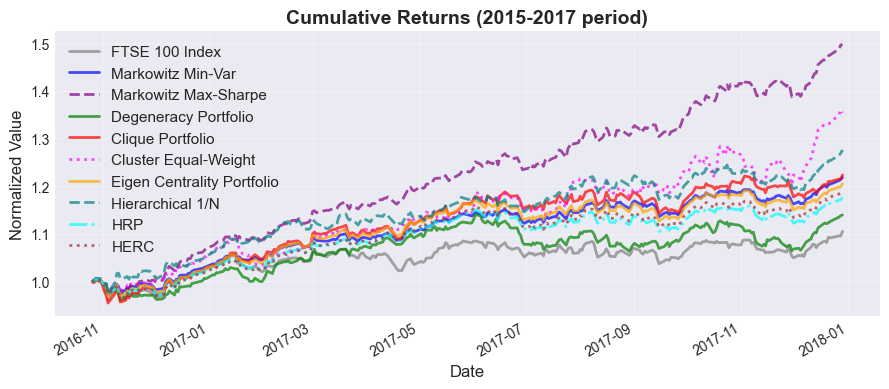

In [74]:
style_map = {
    'FTSE100': ('grey', '-', 'FTSE 100 Index'),
    'markowitz_minvar': ('blue', '-', 'Markowitz Min-Var'),
    'markowitz_maxsharpe': ('purple', '--', 'Markowitz Max-Sharpe'),
    'degeneracy': ('green', '-', 'Degeneracy Portfolio'),
    'clique': ('red', '-', 'Clique Portfolio'),
    'cluster_equal': ('magenta', ':', 'Cluster Equal-Weight'),
    'eigen_central': ('orange', '-', 'Eigen Centrality Portfolio'),
    'hier_1N': ('teal', '--', 'Hierarchical 1/N'),
    'hrp': ('cyan', '-.', 'HRP'),
    'herc': ('brown', ':', 'HERC'),
}
plot_cumulative_returns(
    in_sample_data,
    portfolios,
    style_map,
    'Cumulative Returns (2015-2017 period)'
)

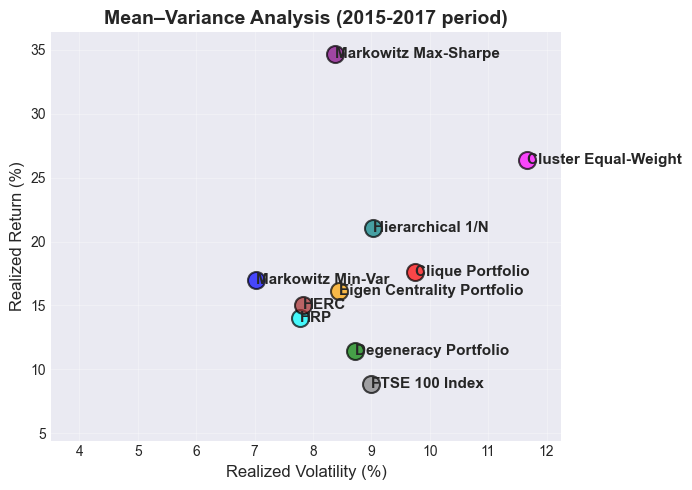

In [75]:
label_map = {
    'FTSE100': 'FTSE 100 Index',
    'markowitz_minvar': 'Markowitz Min-Var',
    'markowitz_maxsharpe': 'Markowitz Max-Sharpe',
    'degeneracy': 'Degeneracy Portfolio',
    'clique': 'Clique Portfolio',
    'cluster_equal': 'Cluster Equal-Weight',
    'eigen_central': 'Eigen Centrality Portfolio',
    'hier_1N': 'Hierarchical 1/N',
    'hrp': 'HRP',
    'herc': 'HERC',
}
color_map = {
    'FTSE100': 'grey',
    'markowitz_minvar': 'blue',
    'markowitz_maxsharpe': 'purple',
    'degeneracy': 'green',
    'clique': 'red',
    'cluster_equal': 'magenta',
    'eigen_central': 'orange',
    'hier_1N': 'teal',
    'hrp': 'cyan',
    'herc': 'brown',
}
plot_mean_variance_scatter(
    in_sample_data,
    portfolios,
    label_map,
    color_map,
    'Mean–Variance Analysis (2015-2017 period)'
)

- In-sample results show clear signs of overfitting. The maximum-Sharpe portfolio delivers 34.64% returns with a Sharpe ratio of 4.13 which is unrealistically high and almost certainly due to fitting noise in the mean estimates. The cluster-equal portfolio comes second at 26.39% returns with Sharpe 2.26 but trades this for higher volatility at 11.67% and substantial tracking error of 11.18%.

- The minimum-variance portfolio achieves Sharpe 2.42 with the lowest volatility at 7.03% which makes sense given its objective. Most network and clustering portfolios land in a reasonable range with Sharpe ratios between 1.80 and 2.33. Hierarchical 1/N performs well at 2.33 Sharpe with 21.09% returns. The degeneracy portfolio sits lower at 1.31 Sharpe but still beats the FTSE 100 benchmark at 0.99.

- In-sample numbers can be misleading especially for methods that rely heavily on mean estimates so we need to see how these portfolios hold up when weights are fixed and markets change.

## 4. Out-of-Sample Performance

- We now evaluate the portfolios over the 2018-2025 period using weights fixed from the in-sample period.

In [76]:
out_sample_data = metadata[out_sample_start:out_sample_end].copy()
out_sample_returns, out_sample_correlation, out_sample_prices = preprocess_returns(
    out_sample_data, components, min_data_availability=MIN_DATA_AVAILABILITY
)
out_sample_data = out_sample_prices.copy()
out_sample_data['FTSE100'] = metadata.loc[out_sample_data.index, 'FTSE100'].ffill()
out_sample_data['degeneracy'] = compute_equal_weighted_portfolio(
    out_sample_data, isolated + independence, 'degeneracy')
out_sample_data['clique'] = compute_equal_weighted_portfolio(
    out_sample_data, clique_selected, 'clique')
out_sample_data['cluster_equal'] = compute_weighted_portfolio(
    out_sample_data, cluster_w, 'cluster_equal')
out_sample_data['eigen_central'] = compute_weighted_portfolio(
    out_sample_data, eigen_w_central, 'eigen_central')
out_sample_data['hier_1N'] = compute_weighted_portfolio(
    out_sample_data, h1n_weights, 'hier_1N')
out_sample_data['hrp'] = compute_weighted_portfolio(
    out_sample_data, hrp_weights_series, 'hrp')
out_sample_data['herc'] = compute_weighted_portfolio(
    out_sample_data, herc_w, 'herc')
out_sample_data['markowitz_minvar'] = compute_weighted_portfolio(
    out_sample_data, minvar_w, 'markowitz_minvar')
out_sample_data['markowitz_maxsharpe'] = compute_weighted_portfolio(
    out_sample_data, maxsharpe_w, 'markowitz_maxsharpe')

In [77]:
ftse100_returns_os = out_sample_data['FTSE100'].pct_change().dropna()
print(f"\n{'='*90}")
print(f"{'Out-of-Sample Performance Metrics (2018–2025)':^90}")
print(f"{'='*90}")
print(f"{'Portfolio':<25} {'Mean Ret':<12} {'Vol':<12} {'Sharpe':<12} {'Max DD':<12} {'Track Err':<12}")
print(f"{'-'*90}")
for portfolio in portfolios:
    if portfolio in out_sample_data.columns:
        returns = out_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        dd = max_drawdown(returns)
        te = tracking_error(returns, ftse100_returns_os) if portfolio != 'FTSE100' else 0.0
        
        print(f"{portfolio:<25} {metrics['mean_return']*100:>10.2f}% "
              f"{metrics['volatility']*100:>10.2f}% {metrics['sharpe_ratio']:>10.4f} "
              f"{dd*100:>10.2f}% {te*100:>10.2f}%")
print(f"{'='*90}\n")


                      Out-of-Sample Performance Metrics (2018–2025)                       
Portfolio                 Mean Ret     Vol          Sharpe       Max DD       Track Err   
------------------------------------------------------------------------------------------
FTSE100                         4.18%      15.67%     0.2669     -36.61%       0.00%
markowitz_minvar                8.52%      15.62%     0.5456     -35.54%       6.79%
markowitz_maxsharpe             9.60%      17.19%     0.5587     -37.83%       9.06%
degeneracy                     10.04%      16.17%     0.6207     -35.90%       8.70%
clique                          6.74%      17.45%     0.3864     -34.67%       7.50%
cluster_equal                  12.75%      17.43%     0.7315     -33.18%      11.79%
eigen_central                   6.73%      16.45%     0.4091     -36.27%       6.42%
hier_1N                         8.94%      16.94%     0.5279     -36.42%       6.48%
hrp                             7.77%      15.

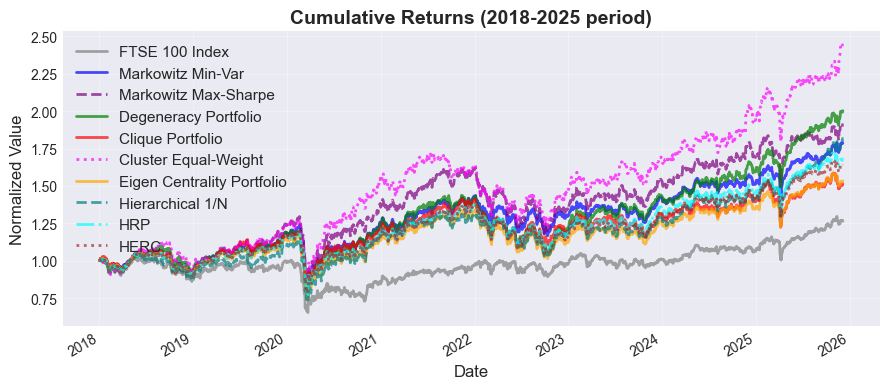

In [78]:
plot_cumulative_returns(
    out_sample_data,
    portfolios,
    style_map,
    'Cumulative Returns (2018-2025 period)'
)

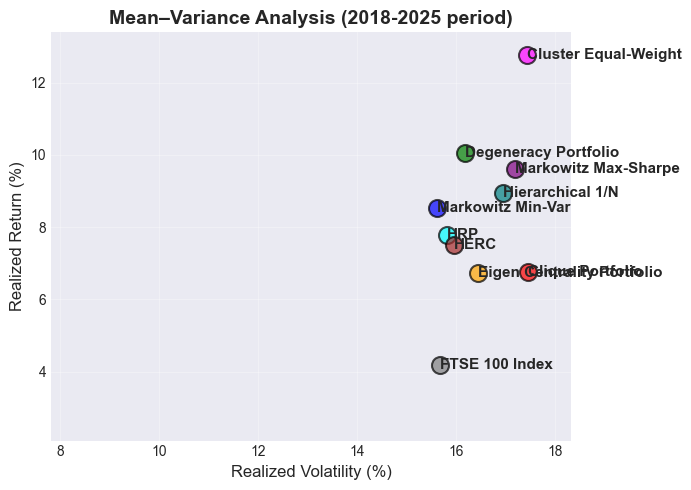

In [79]:
plot_mean_variance_scatter(
    out_sample_data,
    portfolios,
    label_map,
    color_map,
    'Mean–Variance Analysis (2018-2025 period)'
)

- Out-of-sample results tell a different story. The Markowitz portfolios still beat the benchmark but they're no longer dominant. Minimum-variance gets Sharpe 0.55 with 8.52% returns while maximum-Sharpe drops to 0.56 Sharpe with 9.60% returns. Both outperform the FTSE 100 index which only manages Sharpe 0.27 with 4.18% returns and 15.67% volatility.

- The cluster-equal portfolio delivers the best out-of-sample Sharpe at 0.73 with 12.75% returns. The catch is it has the highest tracking error at 11.79% which means it deviates significantly from the benchmark. This might be fine for active managers but could be problematic for index-tracking mandates. The degeneracy portfolio comes second with Sharpe 0.62 and 10.04% returns. It's more balanced with lower tracking error at 8.70% and similar volatility around 16%.

- The clustering portfolios form a solid middle group. Hierarchical 1/N achieves Sharpe 0.53 with 8.94% returns. HRP gets Sharpe 0.49 with 7.77% returns and lower volatility at 15.81%. HERC lands at Sharpe 0.47 with 7.50% returns. All three outperform the benchmark while keeping tracking error reasonable around 6-7%. The eigenvector centrality and clique portfolios also beat the benchmark with Sharpe ratios of 0.41 and 0.39 respectively.

- The main takeaway is that portfolios using correlation structure outperform the index and Markowitz portfolios out-of-sample. Cluster-equal offers the highest risk-adjusted returns but comes with substantial active risk. Degeneracy provides a good middle ground. The clustering methods offer consistent improvements over the benchmark without the extreme tracking error of cluster-equal which makes them attractive for practical applications.

## 5.Final Thoughts

- These portfolios were an experiment not a trading strategy. The FTSE 100 universe stays fixed from 2015 to 2025 and I ignore rebalancing transaction costs and funding. I also assume trading at the last observed price which wouldn't hold in real markets.

- The goal isn't to show Markowitz or index investing is wrong but to compare different ways of using correlation information. Different investors care about different things like higher returns smaller drawdowns or capital preservation. These portfolios are examples of trade-offs not a single best solution.

- For simplicity I use one clean split with 2015-2017 in-sample and 2018-2025 out-of-sample then hold everything buy-and-hold. A real implementation would use rolling windows periodic rebalancing and explicit constraints. Changing these choices would affect the returns.

- I picked FTSE 100 partly to see how these strategies would perform during Brexit and COVID which adds some stress testing. In very concentrated indices these strategies might not work as well since we'd find fewer stocks with low correlations to build diversified portfolios. These results are one case study not a universal recipe.

- I focused on annualized returns volatility and Sharpe ratio which are standard metrics. There are more advanced techniques in network analysis and hierarchical clustering that could extend this work plus coherent risk measures like Expected Shortfall or CVaR and testing across different periods and universes. I kept the scope focused on core portfolio construction methods to maintain precision and stay on topic which is showing some alternative portfolio construction approaches.

## 6. References

- Konstantinov, G. S., & Fabozzi, F. J. (2023). *Network Models in Finance: Expanding the Tools for Portfolio and Risk Management*. Wiley.
- Markowitz, H. (1952). "Portfolio Selection". *Journal of Finance*, 7(1), 77–91.
- López de Prado, M. (2016). "Building Diversified Portfolios that Outperform Out-of-Sample". *Journal of Portfolio Management*, 42(4), 59–69.
- Tumminello, M., Lillo, F., & Mantegna, R. N. (2010). “Correlation, hierarchies, and networks in financial markets”. *Journal of Economic Behavior & Organization*, 75(1), 40–58.